# SWD - Lab 5
Nonlinear dimensionality reduction

## Used algorithms:
 - Classical MSD (PCA)
 - ISOMAP
 - t-SNE
 - UMAP

## Used datasets
- Cars
- Swiss Roll
- Digits

In [1]:
# %matplotlib notebook

In [2]:
from typing import List, Any

In [3]:
import pandas as pd
import numpy as np
from umap import UMAP
from sklearn.manifold import Isomap, TSNE
from sklearn.datasets import make_swiss_roll, load_digits
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

/Users/adam/.local/share/virtualenvs/lab-nzaQv4qd/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


## Helpers

In [4]:
def plot(values: np.ndarray, ax: Any = None, labels: List[str] = None, 
         colors: List[Any] = None, text_size: int = 9, savepath: str = None, 
         ) -> None:
    """ Splits and plots given values as scatter plot with proper 
        projection type. Saves the plot in `savepath` (if defined) """
    
    assert values.shape[1] in [2, 3], 'Invalid input shape!'

    fig = None
    splitted_values = np.hsplit(values, values.shape[1])
    projection_type = '3d' if values.shape[1] == 3 else None
    
    # Plot data
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection=projection_type)
        
    if colors is None:
        ax.scatter(*splitted_values)
    else:
        ax.scatter(*splitted_values, c=colors)
    
    # Add annotations
    if labels is not None:
        for idx, label in enumerate(labels):
            position = [item[idx] for item in splitted_values]
            ax.annotate(label, xy=position, size=text_size)
    
    # Export the chart
    if savepath is not None:
        fig.savefig(savepath, bbox_inches='tight')

In [5]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

class ClassicalMDS():
    def __init__(self, metric: str ='l2', n_components: int = 2) -> None:
        self.metric = metric
        self.n_components = n_components
        self.defined_metrics = {
            'l1': manhattan_distances, 
            'l2': euclidean_distances
        }
        
    def _get_centering_matrix(self, size: int) -> np.ndarray:
        """ Retruns centering matrix """
        return np.eye(size) - 1/size * np.ones((size, size))
        
    def _centering(self, array: np.ndarray) -> np.ndarray:
        """ Centers an array (mean value of rows/cols equals 0)"""
        array = (array - array.min()) / (array.max() - array.min())
        centering_matrix = self._get_centering_matrix(array.shape[0])
        return -0.5 * (centering_matrix @ np.square(array) @ centering_matrix)
        
    def fit_transform(self, points: np.ndarray) -> np.ndarray:
        """ Calculates classical MDS """
        assert len(points.shape) == 2, 'Invalid points shape!'
        
        distance_matrix = self._centering(self.defined_metrics[self.metric](points))
        return PCA(n_components=self.n_components).fit_transform(distance_matrix)


## Load the datasets

In [6]:
cars_url = 'http://www.cs.put.poznan.pl/ibladek/students/skaiwd/lab5/cars.csv'
cars = pd.read_csv(cars_url, header=None)
cars_labels, cars_data = cars.iloc[:, 0].values.tolist(), cars.iloc[:, 1:].values

In [7]:
swiss_roll, swiss_roll_colors = make_swiss_roll(1600)
swiss_roll_data, swiss_roll_labels = swiss_roll, swiss_roll[:, 2].argsort()

In [8]:
digits = load_digits()
digits_data, digits_labels = digits.data, digits.target
colors_mapping = np.linspace(0, 1, 10)
digits_colors = plt.get_cmap('jet')([colors_mapping[idx] for idx in digits_labels])

# Default parameters

In [9]:
default_methods = [
    ['Classical MDS (L2)', ClassicalMDS, {}],
    ['Isomap', Isomap, {}],
    ['t-SNE', TSNE, {}],
    ['UMAP', UMAP, {}]
]

## Cars

/Users/adam/.local/share/virtualenvs/lab-nzaQv4qd/lib/python3.7/site-packages/umap/umap_.py:1674: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


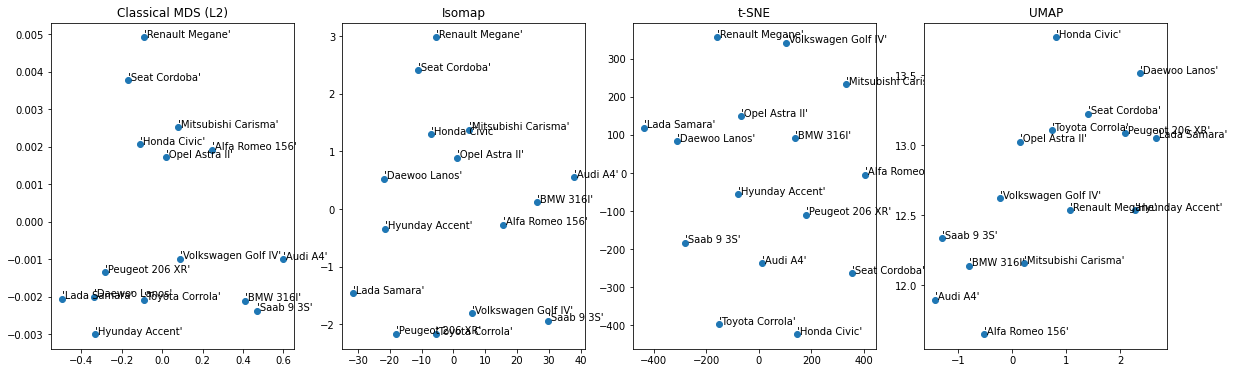

In [10]:
# Cars
num_methods = len(default_methods)
fig = plt.figure(figsize=(20, 6))
data = cars_data
labels = cars_labels

for idx, (method_name, method, params) in enumerate(default_methods, start=1):
    ax = fig.add_subplot(1, num_methods, idx)
    ax.title.set_text(method_name)
    output = method(**params).fit_transform(data)
    plot(output, ax=ax, labels=labels, text_size=10)
    
fig.savefig('cars_default.pdf', bbox_inches='tight')

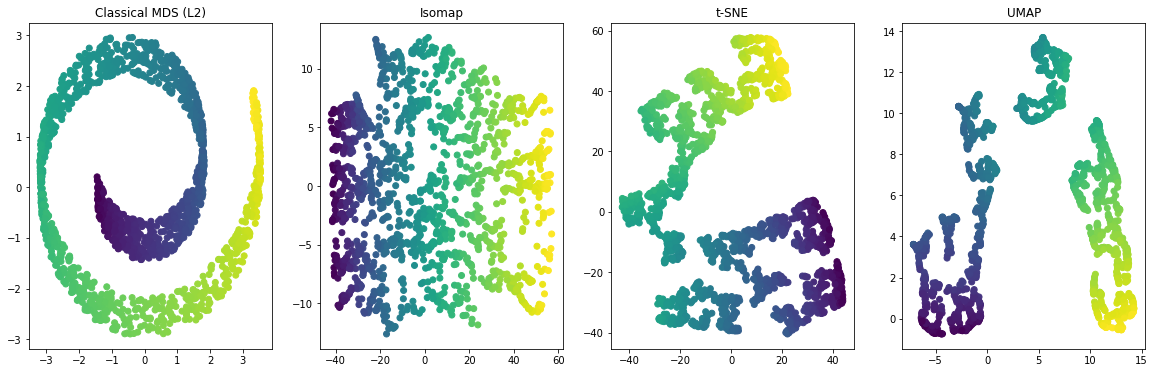

In [11]:
# Swiss roll
num_methods = len(default_methods)
fig = plt.figure(figsize=(20, 6))
data = swiss_roll_data
colors = swiss_roll_colors

for idx, (method_name, method, params) in enumerate(default_methods, start=1):
    ax = fig.add_subplot(1, num_methods, idx)
    ax.title.set_text(method_name)
    output = method(**params).fit_transform(data)
    plot(output, ax=ax, colors=colors, text_size=8)
    
fig.savefig('swiss_default.pdf', bbox_inches='tight')

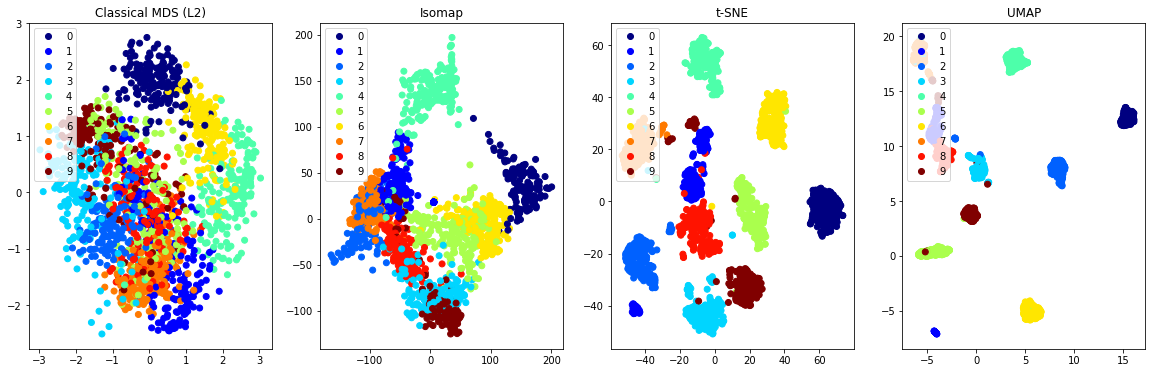

In [12]:
# Digits
num_methods = len(default_methods)
fig = plt.figure(figsize=(20, 6))
data = digits_data
labels = digits_labels
colors = digits_colors

# Legend
custom_lines = [Line2D([0], [0], color=colors[idx], lw=0, marker='o') for idx in range(10)]

for idx, (method_name, method, params) in enumerate(default_methods, start=1):
    ax = fig.add_subplot(1, num_methods, idx)
    ax.title.set_text(method_name)
    ax.legend(custom_lines, [str(idx) for idx in range(10)], loc='upper left')
    output = method(**params).fit_transform(data)
    plot(output, ax=ax, colors=colors, text_size=8)
    
fig.savefig('digits_default.pdf', bbox_inches='tight')

## Tuning

In [13]:
iso_tuning_methods = [
    ['Isomap', Isomap, {'n_neighbors': 3}],
    ['Isomap', Isomap, {'n_neighbors': 5}],
    ['Isomap', Isomap, {'n_neighbors': 9}],
    ['Isomap', Isomap, {'n_neighbors': 15}],
]

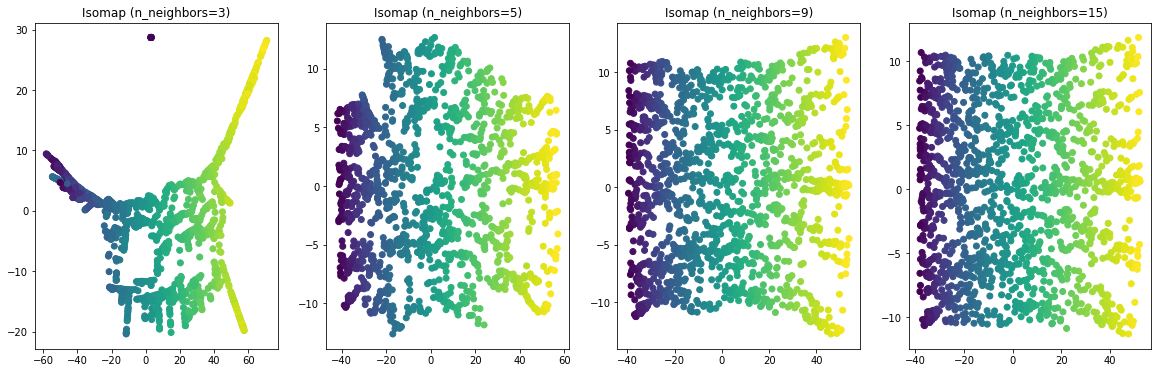

In [14]:
# Swiss
num_methods = len(iso_tuning_methods)
fig = plt.figure(figsize=(20, 6))
data = swiss_roll_data
colors = swiss_roll_colors

for idx, (method_name, method, params) in enumerate(iso_tuning_methods, start=1):
    ax = fig.add_subplot(1, num_methods, idx)
    ax.title.set_text(f'{method_name} (n_neighbors={params["n_neighbors"]})')
    output = method(**params).fit_transform(data)
    plot(output, ax=ax, colors=colors, text_size=8)
    
fig.savefig('swiss_iso_tuning.pdf', bbox_inches='tight')

In [15]:
umap_tuning_methods = [
    ['UMAP', UMAP, {'n_neighbors': 3}],
    ['UMAP', UMAP, {'n_neighbors': 5}],
    ['UMAP', UMAP, {'n_neighbors': 9}],
    ['UMAP', UMAP, {'n_neighbors': 15}],
]

/Users/adam/.pyenv/versions/3.7.3/lib/python3.7/importlib/__init__.py:127: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.registry', please update to use 'numba.core.registry' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  return _bootstrap._gcd_import(name[level:], package, level)
/Users/adam/.local/share/virtualenvs/lab-nzaQv4qd/lib/python3.7/site-packages/umap/spectral.py:106: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'CPUDispatcher' requested from: 'numba.targets.registry', please update to use 'numba.core.registry' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  ) == numba.targets.registry.CPUDispatcher and scipy.sparse.isspmatrix(data):


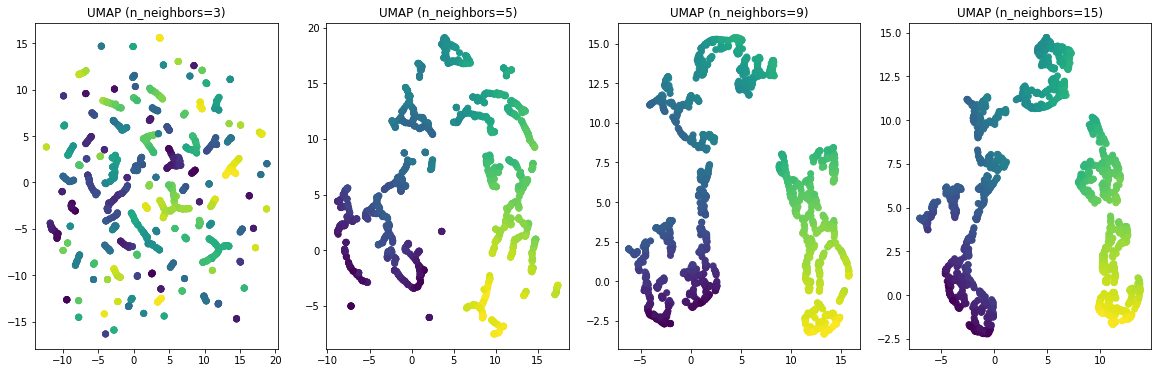

In [16]:
# Swiss
num_methods = len(umap_tuning_methods)
fig = plt.figure(figsize=(20, 6))
data = swiss_roll_data
colors = swiss_roll_colors

for idx, (method_name, method, params) in enumerate(umap_tuning_methods, start=1):
    ax = fig.add_subplot(1, num_methods, idx)
    ax.title.set_text(f'{method_name} (n_neighbors={params["n_neighbors"]})')
    output = method(**params).fit_transform(data)
    plot(output, ax=ax, colors=colors, text_size=8)
    
fig.savefig('swiss_umap_tuning.pdf', bbox_inches='tight')